# Importing Libraries 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.filterwarnings('ignore')
import re
import string
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from collections import Counter, defaultdict
import plotly.graph_objects as go
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords  
from nltk.stem.lancaster import LancasterStemmer  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import pickle
import joblib

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Tru
[nltk_data]     Projects\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing dataset

In [3]:
dataset = pd.read_csv("tripadvisor_hotel_reviews.csv")

# EDA

In [4]:
dataset.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [6]:
dataset.describe()

Rating
count  20491.000000
mean       3.952223
std        1.233030
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000

In [7]:
dataset.isnull().sum()

Review    0
Rating    0
dtype: int64

# There are no null values

# Data Visualization

(array([], dtype=float64), [])

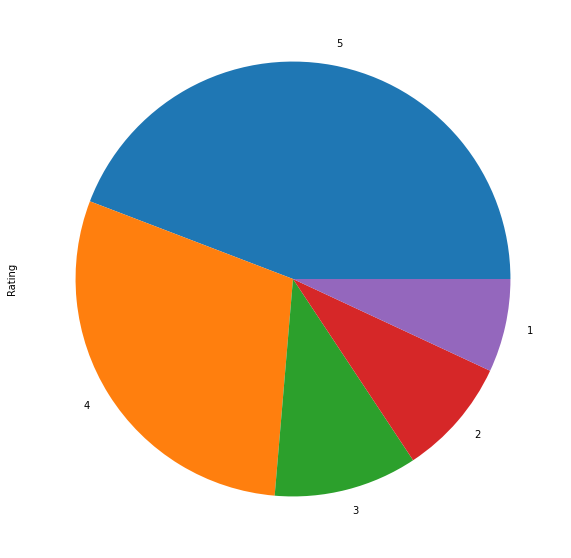

In [8]:
plt.figure(figsize=(15,10))
dataset['Rating'].value_counts().nlargest(20).plot(kind='pie')
plt.xticks(rotation=60)

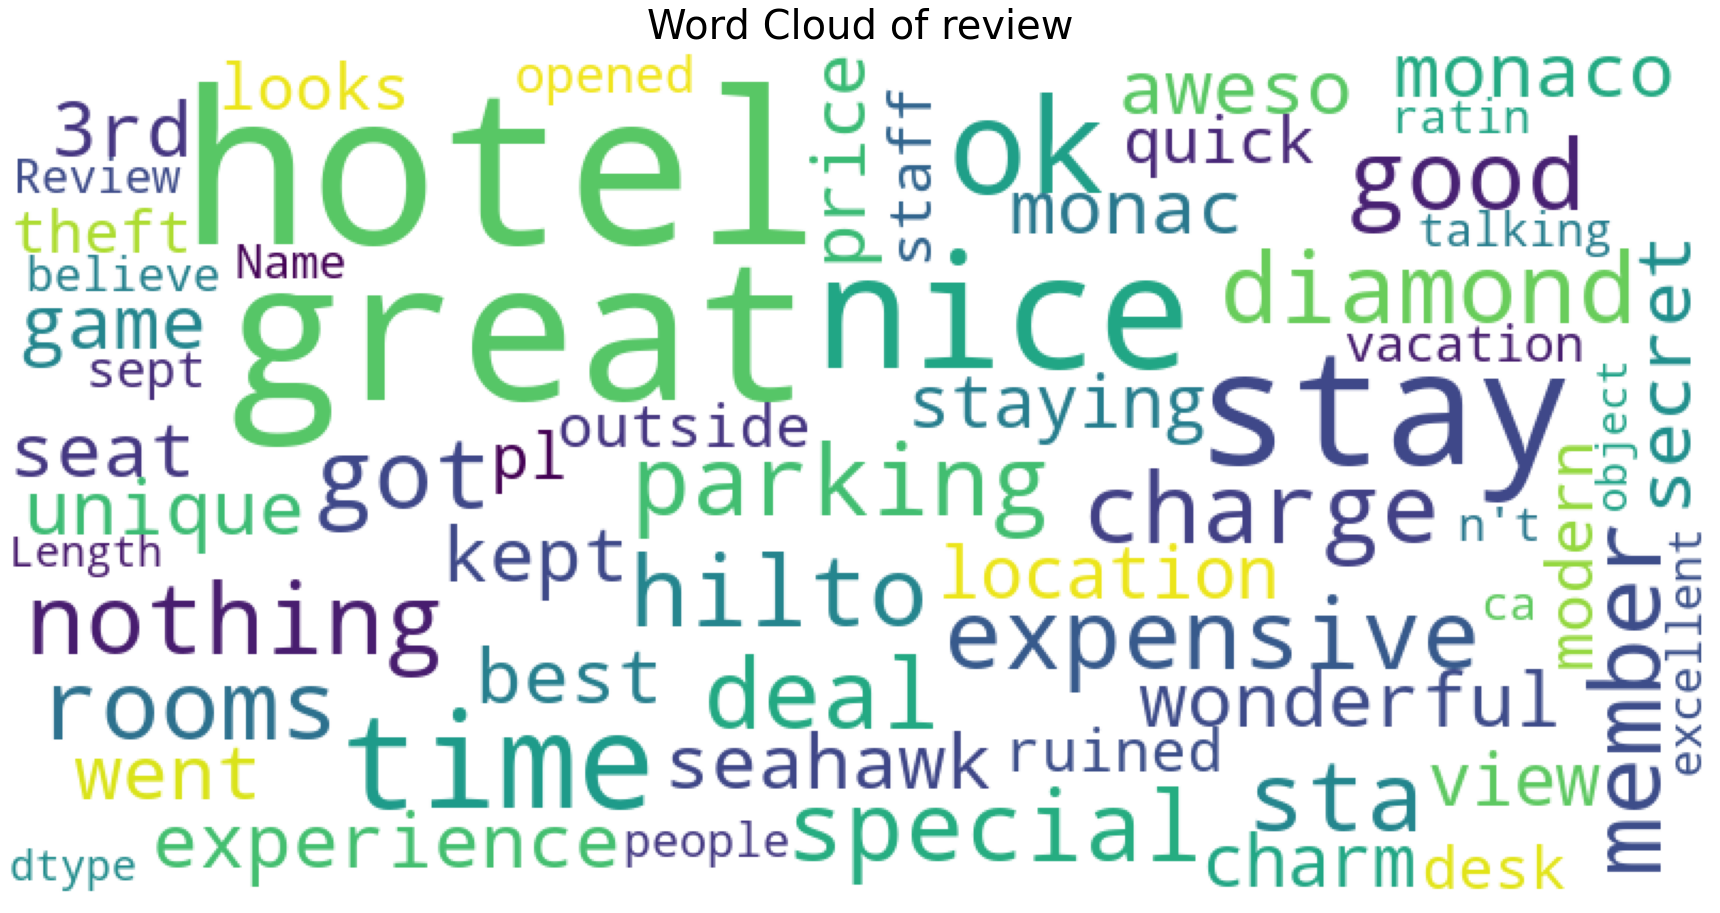

In [9]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(dataset["Review"], title="Word Cloud of review")

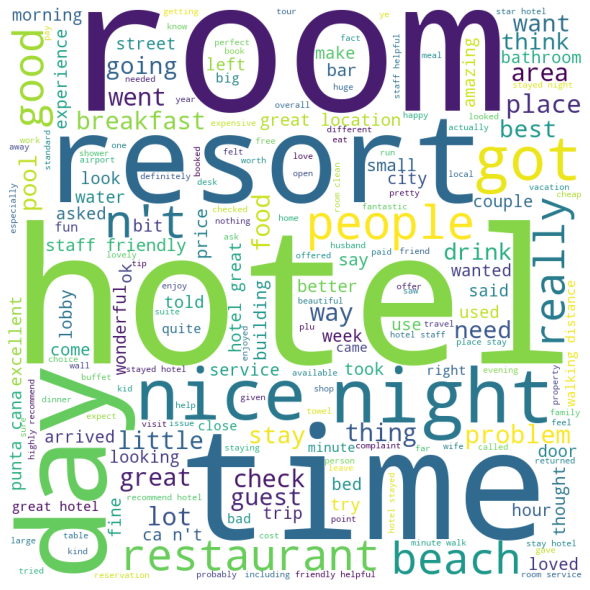

In [10]:
df = dataset
 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in dataset.Review:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Text Pre-processing 

In [11]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
dataset['Review'] = dataset['Review'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [12]:
dataset['Review'][0]

'nice hotel expensive parking got good deal stay hotel anniversary  arrived late evening took advice previous reviews did valet parking  check quick easy  little disappointed non existent view room room clean nice size  bed comfortable woke stiff neck high pillows  not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway  maybe just noisy neighbors  aveda bath products nice  did not goldfish stay nice touch taken advantage staying longer  location great walking distance shopping  overall nice experience having pay   parking night   '

# VADER SCORE

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [14]:
dataset['scores'] = dataset['Review'].apply(lambda hotel_overview: sid.polarity_scores(str(hotel_overview)))
df.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not    experience hotel monaco seat...       3   
3  unique  great stay  wonderful time hotel monac...       5   
4  great stay great stay  went seahawk game aweso...       5   

                                              scores  
0  {'neg': 0.072, 'neu': 0.643, 'pos': 0.285, 'co...  
1  {'neg': 0.109, 'neu': 0.693, 'pos': 0.198, 'co...  
2  {'neg': 0.094, 'neu': 0.658, 'pos': 0.248, 'co...  
3  {'neg': 0.017, 'neu': 0.546, 'pos': 0.437, 'co...  
4  {'neg': 0.107, 'neu': 0.628, 'pos': 0.265, 'co...

In [15]:
dataset['compound'] = dataset['scores'].apply(lambda score_dict: score_dict['compound'])
dataset['sentiment_type']=''
dataset.loc[dataset.compound>0,'sentiment_type']='POSITIVE'
dataset.loc[dataset.compound==0,'sentiment_type']='NEUTRAL'
dataset.loc[dataset.compound<0,'sentiment_type']='NEGATIVE'
dataset.head()

Review  Rating  \
0  nice hotel expensive parking got good deal sta...       4   
1  ok nothing special charge diamond member hilto...       2   
2  nice rooms not    experience hotel monaco seat...       3   
3  unique  great stay  wonderful time hotel monac...       5   
4  great stay great stay  went seahawk game aweso...       5   

                                              scores  compound sentiment_type  
0  {'neg': 0.072, 'neu': 0.643, 'pos': 0.285, 'co...    0.9747       POSITIVE  
1  {'neg': 0.109, 'neu': 0.693, 'pos': 0.198, 'co...    0.9830       POSITIVE  
2  {'neg': 0.094, 'neu': 0.658, 'pos': 0.248, 'co...    0.9906       POSITIVE  
3  {'neg': 0.017, 'neu': 0.546, 'pos': 0.437, 'co...    0.9946       POSITIVE  
4  {'neg': 0.107, 'neu': 0.628, 'pos': 0.265, 'co...    0.9906       POSITIVE

In [16]:
dataset['sentiment_type'].unique()

array(['POSITIVE', 'NEGATIVE', 'NEUTRAL'], dtype=object)

In [17]:
texts = dataset['Review']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

<AxesSubplot:xlabel='sentiment_type', ylabel='count'>

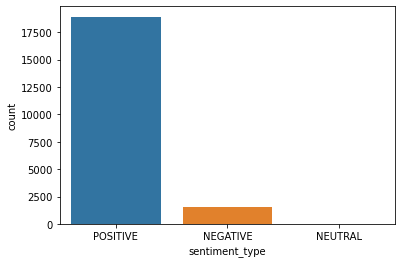

In [18]:
sns.countplot(x = 'sentiment_type',data = dataset)

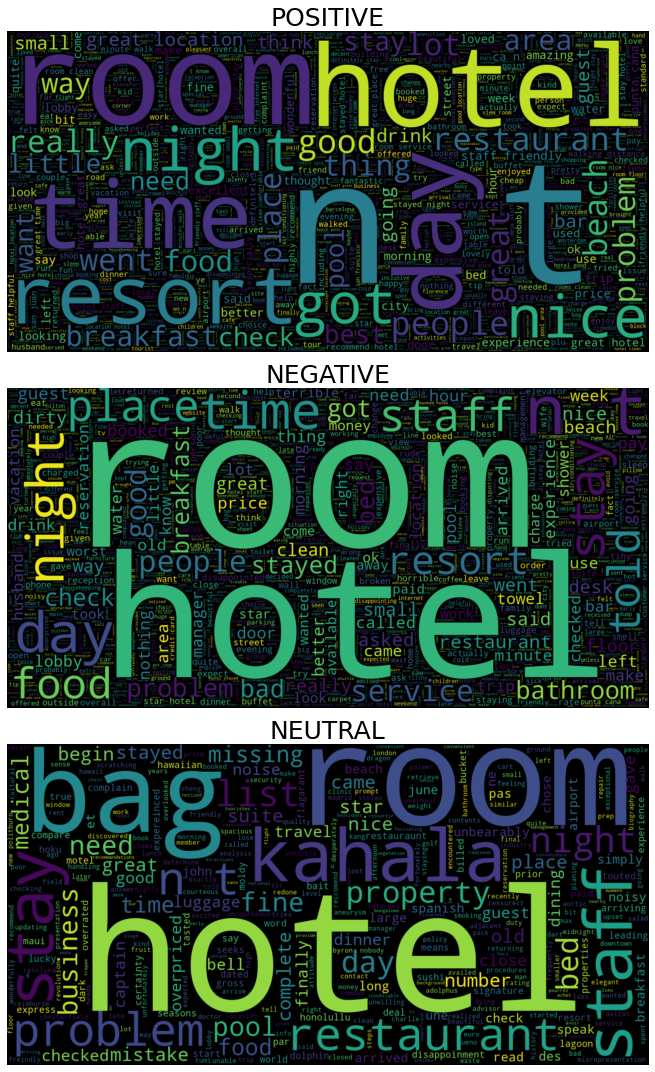

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
sentiments = dataset['sentiment_type'].unique()
for i, senti in enumerate(sentiments):
    senti_df = df.query('sentiment_type==@senti')
    cloud = ' '.join([tweet for tweet in senti_df['Review']])
    wc = WordCloud(max_words=2000, width=1600, \
                   height=800, stopwords=stopwords).generate(cloud)

    ax[i].set_title(senti, fontsize=25)
    ax[i].axis('off')
    ax[i].imshow(wc , interpolation = 'bilinear')
    
plt.tight_layout()
plt.show()

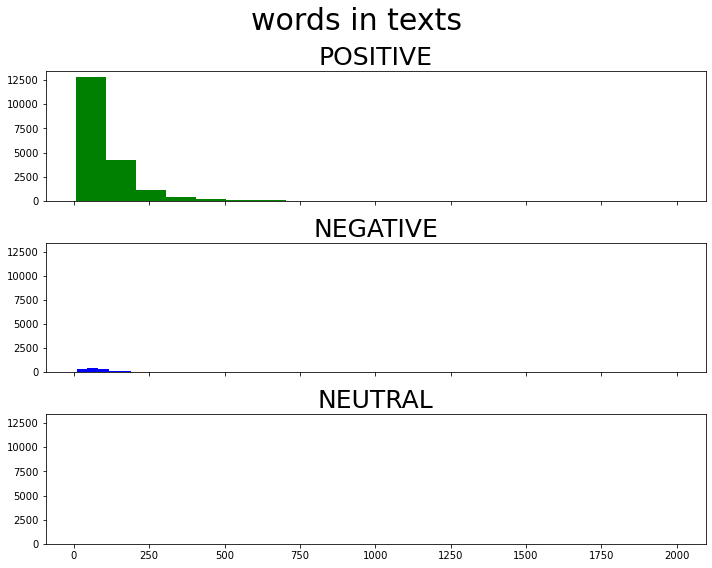

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharey=True, sharex=True)

sentiments = dataset['sentiment_type'].unique()
colors = ['green', 'blue', 'red']
plt.suptitle('words in texts', fontsize=30)
for i, senti in enumerate(sentiments):
    senti_df = df.query('sentiment_type==@senti')
    # number of words in text
    # ex. 'Explain need vaccine' -> 3
    words_len = senti_df['Review'].str.split().map(lambda x: len(x))
    ax[i].set_title(senti, fontsize=25)
    ax[i].hist(words_len, color=colors[i], bins=20)
    
plt.tight_layout()
plt.show()

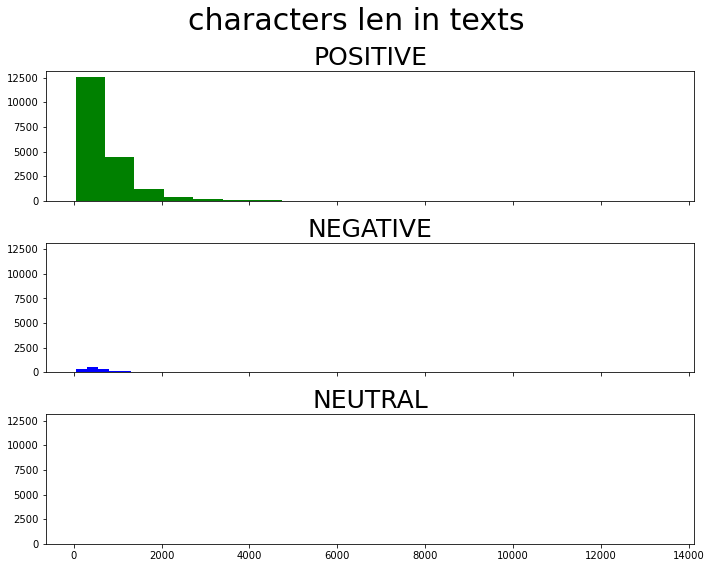

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharey=True, sharex=True)

sentiments = dataset['sentiment_type'].unique()
plt.suptitle('characters len in texts', fontsize=30)
colors = ['green', 'blue', 'red']
for i, senti in enumerate(sentiments):
    posi_df = df.query('sentiment_type==@senti')
    # chars of words in text
    words_len = posi_df['Review'].str.len()
    ax[i].set_title(senti, fontsize=25)
    ax[i].hist(words_len, color=colors[i], bins=20)
    
plt.tight_layout()
plt.show()

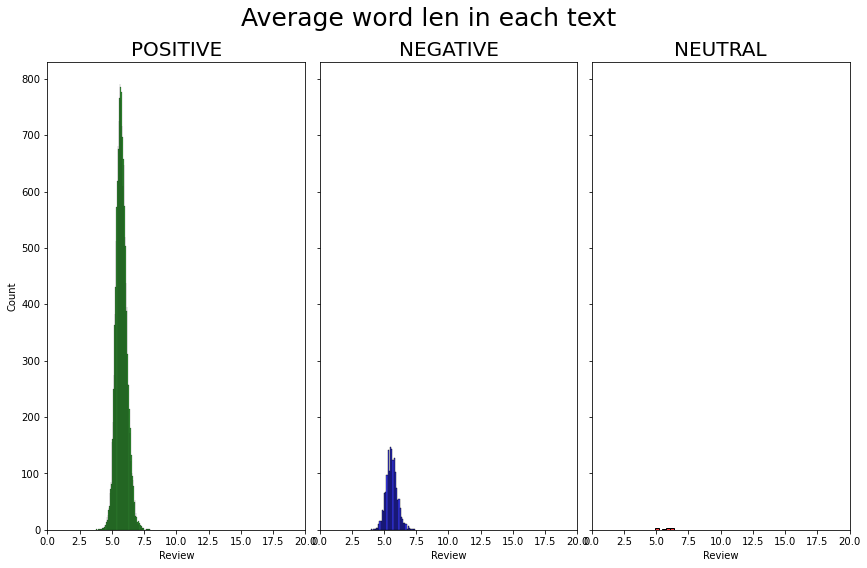

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(12,8), sharey=True, sharex=True)
sentiments = dataset['sentiment_type'].unique()
colors = ['green', 'blue', 'red']
fig.suptitle('Average word len in each text', fontsize=25)

for i, senti in enumerate(sentiments):
    senti_df = df.query('sentiment_type==@senti')
    word = senti_df['Review'].str.split().apply(lambda x: [len(i) for i in x])
    sns.histplot(word.apply(lambda x: np.mean(x)), ax=ax[i], color=colors[i])
    ax[i].set_title(senti, fontsize=20)

plt.tight_layout()
plt.xlim([0, 20])
plt.show()

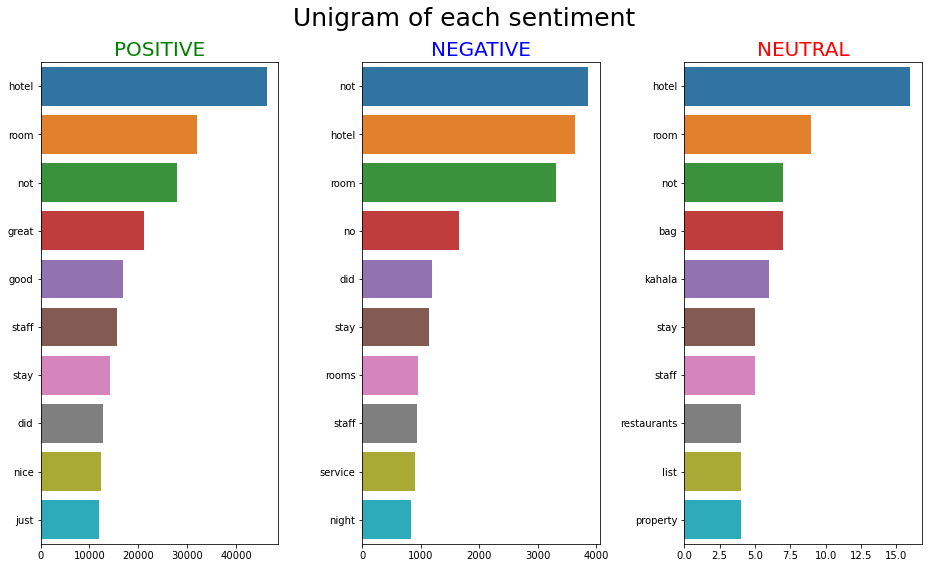

In [23]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, ax = plt.subplots(1, 3, figsize=(13,8))
sentiments = dataset['sentiment_type'].unique()
colors = ['green', 'blue', 'red']
for i, senti in enumerate(sentiments):
    senti_df = senti_df = df.query('sentiment_type==@senti')['Review']
    most_common_bi = get_top_text_ngrams(senti_df,10,1)
    most_common_bi = dict(most_common_bi)
    sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()), ax=ax[i])
    ax[i].set_title(senti, fontsize=20, color=colors[i])

plt.suptitle('Unigram of each sentiment', fontsize=25)
plt.tight_layout()
plt.show()

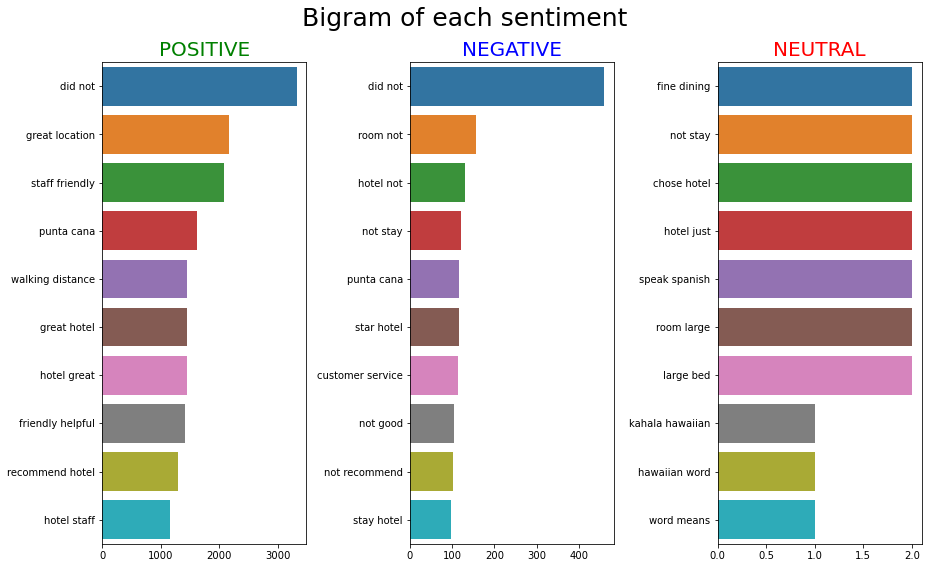

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(13,8))
sentiments = dataset['sentiment_type'].unique()
colors = ['green', 'blue', 'red']
for i, senti in enumerate(sentiments):
    senti_df = senti_df = df.query('sentiment_type==@senti')['Review']
    most_common_bi = get_top_text_ngrams(senti_df, 10, 2)
    most_common_bi = dict(most_common_bi)
    sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()), ax=ax[i])
    ax[i].set_title(senti, fontsize=20, color=colors[i])

plt.suptitle('Bigram of each sentiment', fontsize=25)
plt.tight_layout()
plt.show()

# conclusion

they are more positive reviews than negative and neutral

# Applying Algorithms 

In [25]:
dataset['target'] = dataset['sentiment_type']

In [26]:
dataset

Review  Rating  \
0      nice hotel expensive parking got good deal sta...       4   
1      ok nothing special charge diamond member hilto...       2   
2      nice rooms not    experience hotel monaco seat...       3   
3      unique  great stay  wonderful time hotel monac...       5   
4      great stay great stay  went seahawk game aweso...       5   
...                                                  ...     ...   
20486  best kept secret   time staying charm  not   s...       5   
20487  great location price view hotel great quick pl...       4   
20488  ok just looks nice modern outside  desk staff ...       2   
20489  hotel theft ruined vacation hotel opened sept ...       1   
20490  people talking  ca n t believe excellent ratin...       2   

                                                  scores  compound  \
0      {'neg': 0.072, 'neu': 0.643, 'pos': 0.285, 'co...    0.9747   
1      {'neg': 0.109, 'neu': 0.693, 'pos': 0.198, 'co...    0.9830   
2      {'neg': 0.094, 'neu': 0.658, 'pos': 0.248, 'co...    0.9906   
3      {'neg': 0.017, 'neu': 0.546, 'pos': 0.437, 'co...    0.9946   
4      {'neg': 0.107, 'neu': 0.628, 'pos': 0.265, 'co...    0.9906   
...                                                  ...       ...   
20486  {'neg': 0.09, 'neu': 0.623, 'pos': 0.287, 'com...    0.9816   
20487  {'neg': 0.0, 'neu': 0.568, 'pos': 0.432, 'comp...    0.9790   
20488  {'neg': 0.092, 'neu': 0.722, 'pos': 0.187, 'co...    0.8122   
20489  {'neg': 0.163, 'neu': 0.66, 'pos': 0.176, 'com...    0.9606   
20490  {'neg': 0.103, 'neu': 0.646, 'pos': 0.251, 'co...    0.9476   

      sentiment_type    target  
0           POSITIVE  POSITIVE  
1           POSITIVE  POSITIVE  
2           POSITIVE  POSITIVE  
3           POSITIVE  POSITIVE  
4           POSITIVE  POSITIVE  
...              ...       ...  
20486       POSITIVE  POSITIVE  
20487       POSITIVE  POSITIVE  
20488       POSITIVE  POSITIVE  
20489       POSITIVE  POSITIVE  
20490       POSITIVE  POSITIVE  

[20491 rows x 6 columns]

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['target'] = le.fit_transform(dataset['target'])

In [32]:
dataset['sentiment_type'][77]

'NEGATIVE'

In [33]:
dataset.iloc[77]

Review            single rooms like hospital rooms single rooms ...
Rating                                                            1
scores            {'neg': 0.209, 'neu': 0.641, 'pos': 0.151, 'co...
compound                                                    -0.4201
sentiment_type                                             NEGATIVE
target                                                            0
Name: 77, dtype: object

In [36]:
data = dataset[['Review','target']]

In [37]:
data

Review  target
0      nice hotel expensive parking got good deal sta...       2
1      ok nothing special charge diamond member hilto...       2
2      nice rooms not    experience hotel monaco seat...       2
3      unique  great stay  wonderful time hotel monac...       2
4      great stay great stay  went seahawk game aweso...       2
...                                                  ...     ...
20486  best kept secret   time staying charm  not   s...       2
20487  great location price view hotel great quick pl...       2
20488  ok just looks nice modern outside  desk staff ...       2
20489  hotel theft ruined vacation hotel opened sept ...       2
20490  people talking  ca n t believe excellent ratin...       2

[20491 rows x 2 columns]

In [38]:
data.to_csv("cleaned.csv")